<a href="https://colab.research.google.com/github/SamwelJane/Recommendation-ML-model--Retailers/blob/master/retail_price_recommendation_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# importing labraries
import warnings
import time
import os 
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import lightgbm as lgb

from sklearn.preprocessing import LabelBinarizer
# To ignore warnings any
warnings.filterwarnings('ignore')


LOADING DATA FROM DRIVE

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# DATA DESCRIPTION

* train_id — the id of the listing
* name — the title of the listing
* item_condition_id — the condition of the items provided by the sellers
* category_name — category of the listing
* brand_name — the name of the brand
* price — the price that the item was sold for. This is target variable that we will predict
* shipping — 1 if shipping fee is paid by seller and 0 by buyer
* item_description — the full description of the item

In [0]:
# defining our dataframe as retail
retail = pd.read_csv('/content/drive/My Drive/retail/train.tsv', sep = '\t')


In [6]:
# previewing the first row
retail.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [7]:

# dataframe info
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [8]:
# checking null values
 retail.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

In [10]:
# creating a function that check for missing values

def checking_missing_values(df):
    '''
    Takes df
    Checks nulls
    '''
    if df.isnull().sum().sum() > 0:
        mask_total = df.isnull().sum().sort_values(ascending=False) 
        total = mask_total[mask_total > 0]

        mask_percent = df.isnull().mean().sort_values(ascending=False)*100 
        percent = mask_percent[mask_percent > 0] 

        missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    
        print(f'Total and Percentage of NaN:\n {missing_data}')
    else: 
        print('No NaN found.')
checking_missing_values(retail) 

Total and Percentage of NaN:
                    Total    Percent
brand_name        632682  42.675687
category_name       6327   0.426769
item_description       4   0.000270


In [11]:
#  price
retail.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

In [12]:
#  Since we have test dataset  i will split my split dataset to train and test
# The test dataset will be used as validation set before running the test in the model
retail_st = np.random.rand(len(retail)) <0.8

train_r =retail[retail_st]
test_r = retail[retail_st]
train_r.shape, test_r.shape

((1185381, 8), (1185381, 8))

In [0]:
def histograms_numeric_columns(df,numerical_columns):
    '''
    Takes df,numerical_columns as list
    Return a group of histograms
    '''
    f= pd.melt(df,value_vars=numerical_columns)
    g= sns.FacetGrid(f,col='variable',col_wrap=4,sharex=False,sharey=False)
    g=g.map(sns.distplot,'value')
    return g

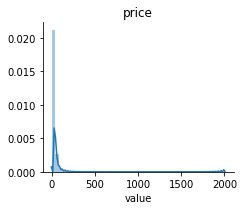

In [17]:
figure=(10,10)
histograms_numeric_columns(train_r,'price');
plt.title('price')
plt.show()

Text(0.5, 1.0, 'Price distribution')

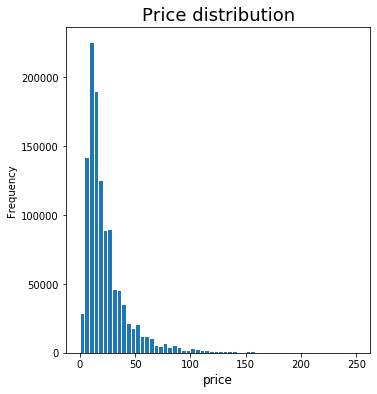

In [68]:
plt.subplot(1,2,1)
(train_r['price']).plot.hist(bins= 60, figsize=(12,6),edgecolor = 'white',range=[0,250])
plt.xlabel('price',fontsize= 12)
plt.title('Price distribution',fontsize= 18)



Most of the items cost between 10-25  and top frequency was above 200000

The price was right skewed

Text(0.5, 1.0, 'Price Distribution')

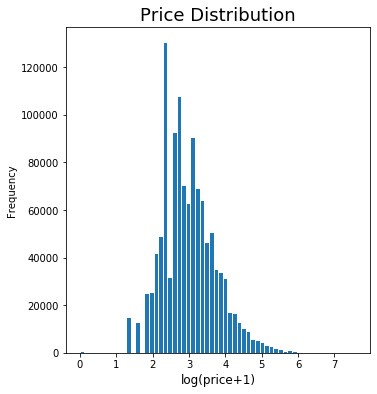

In [67]:
# to allow normal distribustion of price we shall use log tranformation
plt.subplot(1,2,1)
np.log(train_r['price']+1).plot.hist(bins=60,figsize=(12,6),edgecolor='white')
plt.xlabel('log(price+1)', fontsize=12)
plt.title('Price Distribution',fontsize=18)

In [0]:
def heatmap_numeric_w_dependent_variable(df, dependent_variable):
    '''
    Takes df, a dependant variable as str
    Returns a heatmap of all independent variables' correlations with dependent variable 
    '''
    plt.figure(figsize=(8, 10))
    g = sns.heatmap(df.corr()[[dependent_variable]].sort_values(by=dependent_variable), 
                    annot=True, 
                    cmap='coolwarm', 
                    vmin=-1,
                    vmax=1) 
    plt.title('Heatmap of numerical with dependent variables',fontsize= 15)
    return g

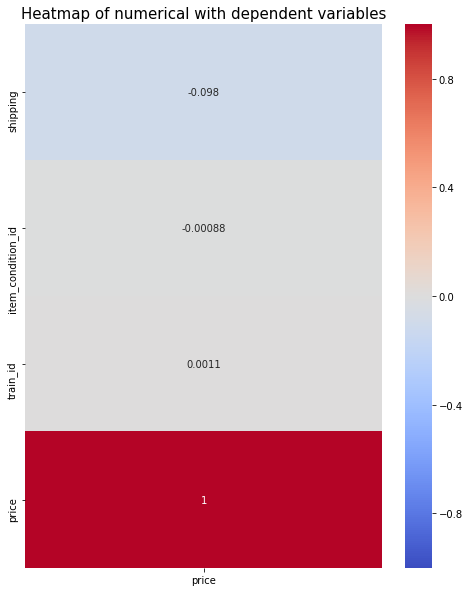

In [21]:
heatmap_numeric_w_dependent_variable(train_r,'price');

Correlation of price to ther factors in the dataset that determine the price

shipping affect price most than any other variable

In [22]:
# percentage of shipping items that were bought and those that weren't bought
print(train_r['shipping'].value_counts()/len(train_r))
print('over 55% of the shipping fee were paid by buyer')

0    0.552481
1    0.447519
Name: shipping, dtype: float64
over 55% of the shipping fee were paid by buyer


## relation of shipping  to price charges

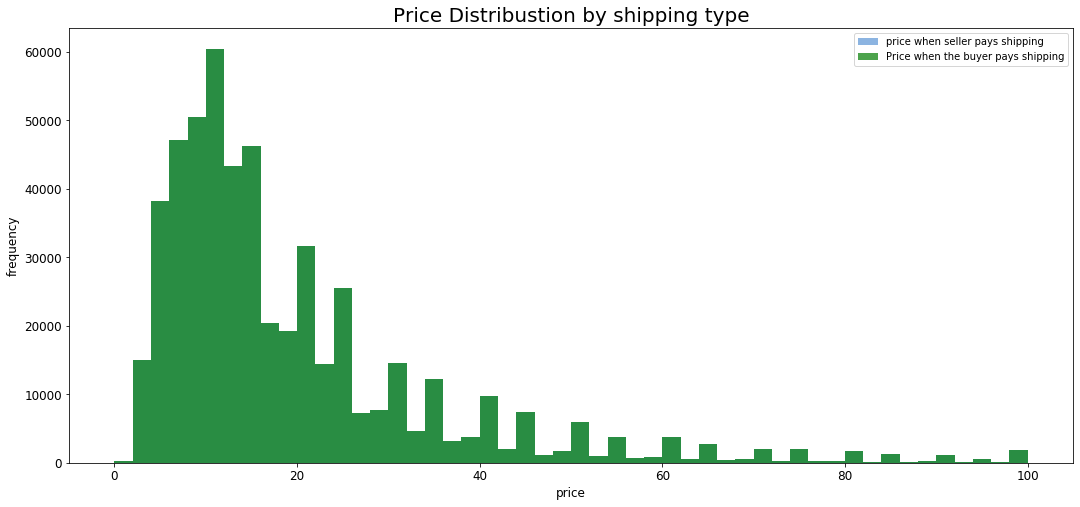

In [23]:
shipping_fee_by_buyer = train_r.loc[retail['shipping']==0,'price']
shipping_fee_by_seller = train_r.loc[retail['shipping']==1,'price']

fig, ax =plt.subplots(figsize=(18,8))
ax.hist(shipping_fee_by_seller,color = '#8CB4E1',alpha= 1.0,bins=50,range= [0,100],label='price when seller pays shipping')
ax.hist(shipping_fee_by_seller,color='#007D00',alpha=0.7,bins=50,range =[0,100],label = 'Price when the buyer pays shipping')
plt.xlabel('price',fontsize=12)
plt.ylabel('frequency',fontsize=12)
plt.title('Price Distribustion by shipping type',fontsize=20)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()

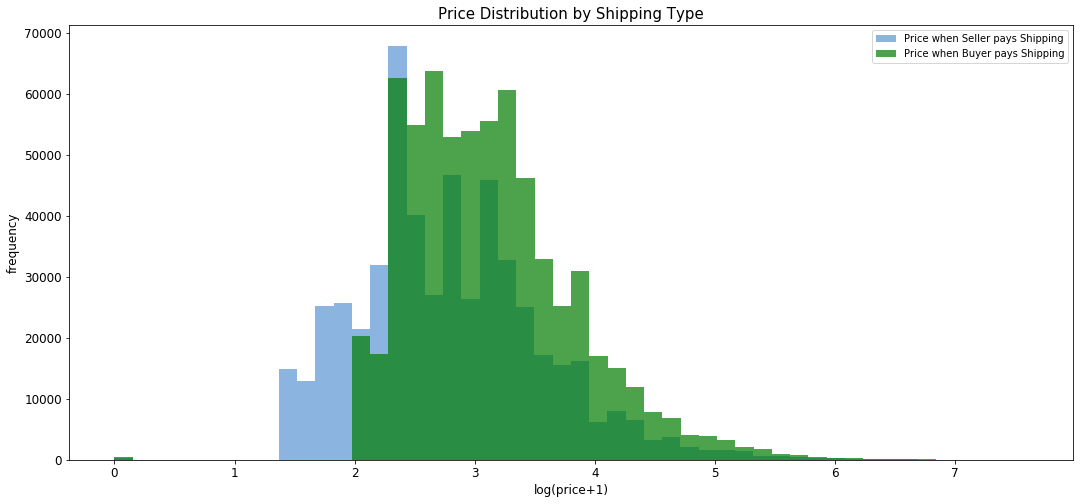

In [24]:
# using log
fig, ax = plt.subplots(figsize=(18,8))
ax.hist(np.log(shipping_fee_by_seller+1), color='#8CB4E1', alpha=1.0, bins=50,
       label='Price when Seller pays Shipping')
ax.hist(np.log(shipping_fee_by_buyer+1), color='#007D00', alpha=0.7, bins=50,
       label='Price when Buyer pays Shipping')
plt.xlabel('log(price+1)', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()



 log makes the data to change it skewness 

In [25]:
# Top 10 most common category names
train_r['category_name'].value_counts()[:10]

Women/Athletic Apparel/Pants, Tights, Leggings                 48237
Women/Tops & Blouses/T-Shirts                                  37065
Beauty/Makeup/Face                                             27395
Beauty/Makeup/Lips                                             23870
Electronics/Video Games & Consoles/Games                       21274
Beauty/Makeup/Eyes                                             20278
Electronics/Cell Phones & Accessories/Cases, Covers & Skins    19778
Women/Underwear/Bras                                           16982
Women/Tops & Blouses/Blouse                                    16197
Women/Tops & Blouses/Tank, Cami                                16175
Name: category_name, dtype: int64

## Item condition  and its Price

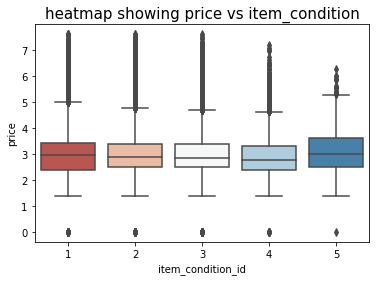

In [26]:
sns.boxplot(x = 'item_condition_id',y = np.log(train_r['price']+1),data=train_r,palette=sns.color_palette('RdBu',5))
plt.title('heatmap showing price vs item_condition',fontsize=15)
plt.show()



most of the items were above the upper limit price and they are signs of outliers. we also prices that were zero

The average price of items bought is 3

In [0]:
NUM_BRANDS = 4000
NUM_CATEGORIES = 1000
NAME_MIN_DF = 10
MAX_FEATURES_ITEM_DESCRIPTION = 50000

Dealing  with missing values using functions

In [0]:
def handle_missing_inplace(dataset): 
    dataset['category_name'].fillna(value='missing', inplace=True) 
    dataset['brand_name'].fillna(value='missing', inplace=True) 
    dataset['item_description'].replace('No description yet,''missing', inplace=True) 
    dataset['item_description'].fillna(value='missing', inplace=True)
def cutting(dataset):
    pop_brand = dataset['brand_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_BRANDS]
    dataset.loc[~dataset['brand_name'].isin(pop_brand), 'brand_name'] = 'missing'
    pop_category = dataset['category_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_CATEGORIES]
def to_categorical(dataset):
    dataset['category_name'] = dataset['category_name'].astype('category')
    dataset['brand_name'] = dataset['brand_name'].astype('category')
    dataset['item_condition_id'] = dataset['item_condition_id'].astype('category')

In [30]:
retail.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

In [0]:
# drop rows where the price is zero

#retail = pd.read_csv('train.tsv',sep = '\t')
retail_nd = np.random.rand(len(retail))< 0.8
train = retail[retail_nd]
validation =retail[~retail_nd]
validation_new = validation.drop('price',axis=1)
y_validation = np.log1p(validation['price'])

train =train[train.price !=0].reset_index(drop=True)

In [0]:
# merging train and new validation

nrow_train = train.shape[0]
y = np.log1p(train["price"])
merge: pd.DataFrame =pd.concat([train,validation_new])

### Prepare training

In [0]:
handle_missing_inplace(merge)
cutting(merge)
to_categorical(merge)

In [0]:
# count vectorize name and categoty name column

cv = CountVectorizer(min_df=NAME_MIN_DF)
X_name = cv.fit_transform(merge['name'])
cv = CountVectorizer()
X_category = cv.fit_transform(merge['category_name'])

In [0]:
tv = TfidfVectorizer(max_features=MAX_FEATURES_ITEM_DESCRIPTION, ngram_range=(1, 3), stop_words='english')
X_description = tv.fit_transform(merge['item_description'])

label inarize the brand name column

In [0]:
lb = LabelBinarizer(sparse_output=True)
X_brand = lb.fit_transform(merge['brand_name'])

In [39]:
merge.shipping.unique()

array([1, 0])

creating dummies variable for item_condition_id and shipping columns

In [0]:
X_dummies = csr_matrix(pd.get_dummies(merge[['item_condition_id']], sparse=True).values)


In [0]:
sparse_merge = hstack((X_dummies, X_description, X_brand, X_category, X_name)).tocsr()


In [0]:
mask = np.array(np.clip(sparse_merge.getnnz(axis=0) - 1, 0, 1), dtype=bool)
sparse_merge = sparse_merge[:, mask]

In [0]:
# separating train and test data from the spare merge
X = sparse_merge[:nrow_train]
X_test = sparse_merge[nrow_train:]    

In [0]:
train_X = lgb.Dataset(X, label=y)

In [0]:
# parameter 
# since our target is contineous  we shall use regression instead of classifer  and the metric of success is RMSE
params = {
        'learning_rate': 0.75,
        'application': 'regression',
        'max_depth': 3,
        'num_leaves': 100,
        'verbosity': -1,
        'metric': 'RMSE',
    }

## traning model

In [0]:
gbm = lgb.train(params, train_set=train_X, num_boost_round=3200, verbose_eval=100)

## making prediction

In [0]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)


In [62]:
y_pred.mean()

2.9843481698122107

In [66]:
# prediction based on the model trained
comparison_frame = pd.DataFrame({'Actual': y_validation, 'Predicted': y_pred})

comparison_frame.describe()


,Actual,Predicted
count,295501.000000,295501.000000
mean,2.979821,2.984348
std,0.750544,0.604998
min,0.000000,0.689096
25%,2.397895,2.582282
50%,2.890372,2.895786
75%,3.401197,3.305663
max,7.601402,8.240219


In [61]:
# from sklearn.metrics import mean_squared_error
# print('The rmse of prediction is:', mean_squared_error(y_validation, y_pred) ** 0.5)

The rmse of prediction is: 0.4702454201907496


In [81]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_validation, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_validation, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_validation, y_pred)))


Mean Absolute Error: 0.3507851432873171
Mean Squared Error: 0.22113075521037465
Root Mean Squared Error: 0.4702454201907496
